## GANs

It is a neural network architecture, with the aim of obtaining models capable of generating realistic data, mainly images. They are a class of artificial intelligence algorithms used in unsupervised learning, implemented by a system of two neural networks that compete with each other in a kind of zero-sum game.

The basic architecture of GANs is made up of two neural networks:

* The generator: receives random values at the input (normally obtained from a Gaussian-type distribution) and outputs an image. You can view the random input as a latent representation (or encoding) of the generated image.
* The discriminator: receives an image (real or generated by the generator) at the input and has to decide whether the image is real or false.



## Dataset

MNIST Fashion Dataset, is made up of 60,000 low-resolution images (28 x 28 pixels, black and white) and contains 10 types of clothing (t-shirts, pants, etc).

In [ ]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

classes = ("t-shirt", "trousers", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot")

At the end of the generator we use a tanh activation, which will give values between -1 and 1. For this reason we have to re-normalize our images in the dataset.

In [ ]:
import numpy as np

class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
    self.imgs = self.imgs * 2. - 1.
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(trainset)
len(train)

In [ ]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]),
 torch.float32,
 tensor(1., device='cuda:0'),
 tensor(-1., device='cuda:0'))

In [ ]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

## Model (DCGANs)

We can use 'DCGANs' (deep convolutional GANs) to get better generators using convolutional networks. In this case, we will need different architectures for generator and discriminator.

The generator will receive a vector of 100 random values and then we will apply several layers of transposed convolutions (which will increase the size of the feature maps), until we obtain the generated image.

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100
        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 7*7*128),
            nn.BatchNorm1d(7*7*128),
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 128, 7, 7)
        x = self.main(x)
        x = x.view(x.size(0), 28*28)
        return x

In [ ]:
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 784])

As for the discriminator, we will use a typical CNN like the ones we know when we do image classification.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.out = nn.Sequential(
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # expect vectors at input of 28*28
        x = x.view(x.size(0), 1, 28, 28)
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

In [ ]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 28*28))
output.shapem

torch.Size([64, 1])

## Trainig

In [ ]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=30, crit=None):
    g.to(device)
    d.to(device)
    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
    crit = nn.BCEWithLogitsLoss() if crit == None else crit
    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}
    for epoch in mb:
        for X, y in progress_bar(dataloader, parent=mb):
            # X, y = X.to(device), y.to(device)  
            # train the discriminator
            g.eval()
            d.train()
            # generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # discriminator input
            d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
            # ground truth for the discriminator
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
            # optimization
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())
            # train the generator
            g.train()
            d.eval()
            # generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # discriminator outputs
            d_output = d(genenerated_images)
            # ground truth for the generator
            g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
            # optimization
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())
            # logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))    
        hist['d_loss'].append(np.mean(d_loss))
    return hist

In [ ]:
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss())

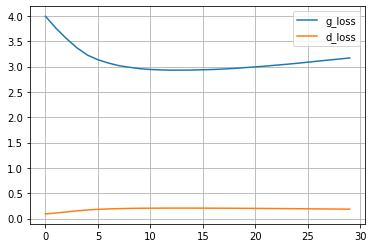

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

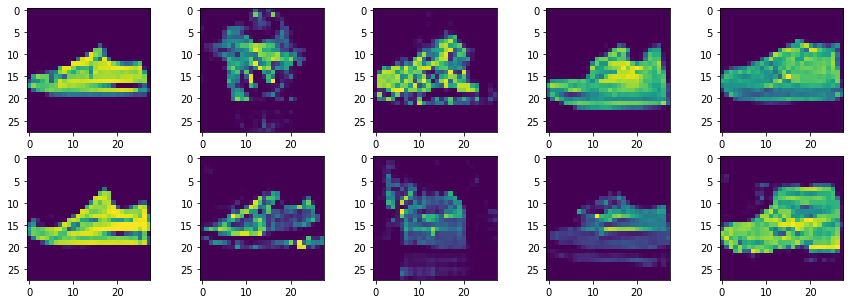

In [ ]:
generator.eval()
with torch.no_grad():
    noise = torch.randn((10, generator.input_size)).to(device)
    generated_images = generator(noise)
    fig, axs = plt.subplots(2,5,figsize=(15,5))
    i = 0
    for ax in axs:
        for _ax in ax:
            img = generated_images[i].view(28,28).cpu()
            _ax.imshow(img)
            i+=1
    plt.show()

In this case, the generated images are slightly better than those obtained with the simple GAN (MLP), although there is still room for improvement.